In [2]:
"""
Apply on UA-DETRAC Dataset

"""
%pylab inline
import os
import keras
import cv2
import time
import numpy as np
import pandas as pd
import keras.backend as K
import tensorflow as tf

import sklearn.metrics as metrics

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten,Reshape, UpSampling2D, Cropping2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import h5py

import sys


from sklearn.cluster import KMeans


os.environ["CUDA_VISIBLE_DEVICES"]="0"

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [3]:
os.getcwd()
home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'train_images')
data_dir

'/Users/azwreith/Documents/Eva/data/ua_detrac/train_images'

In [4]:
def load_images_nn(image_dir, downsize_rate = 1):
    """
    Loading images in a non normalized form
    :param image_dir:
    :param downsize_rate:
    :param grayscale:
    :return:
    """
    image_height = 540
    image_width = 960
    file_names = []
    print(image_dir)
    #tmp = '/nethome/jbang36/eva/data/ua_detrac'
    mvi_dir = os.listdir(image_dir)
    mvi_dir.sort()
    
    for mvi in mvi_dir:
        if mvi == "README.md" or mvi == "download.sh" or mvi == "unzip.sh":
            continue
        image_files = os.listdir(os.path.join(image_dir, mvi))
        image_files.sort()
        for image_file in image_files:
            file_names.append(os.path.join(image_dir, mvi, image_file))
        
    print("Length of file_names", len(file_names))
    print(file_names[0])

    
    img_table = np.ndarray(shape=(len(file_names), int(image_height / downsize_rate), int(image_width / downsize_rate)))
    
    for i in range(len(file_names)):
        file_name = file_names[i]
        img = cv2.imread(file_name,0)
        img = cv2.resize(img, (image_width // downsize_rate, image_height // downsize_rate))
        img_table[i] = img

    return img_table

image_table = load_images_nn(data_dir, downsize_rate = 12)

/Users/azwreith/Documents/Eva/data/ua_detrac/train_images
Length of file_names 6021
/Users/azwreith/Documents/Eva/data/ua_detrac/train_images/MVI_20011/img00001.jpg


In [5]:
# split the training and test data
image_table = image_table[:,:,:,np.newaxis]

n_samples = image_table.shape[0]
train_x = image_table[:int(n_samples * 0.8)]
test_x = image_table[int(n_samples * 0.8):]

In [6]:
image_table.shape

(6021, 45, 80, 1)

(45, 80, 1)
(45, 80)
(45, 80)


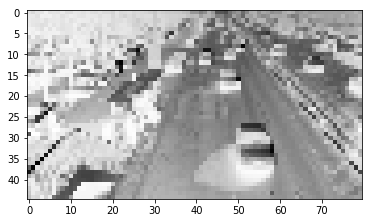

In [7]:
import matplotlib.pyplot as plt
import random
image_index = random.randint(0,100) # You may select anything up to 60,000
print(train_x[image_index].shape)

example = train_x[image_index]
width, height, channels = example.shape
example = np.squeeze(example)
print(np.squeeze(example).shape)
print(example.shape)

plt.imshow(example, cmap='Greys')

In [8]:
# Must perform normalization for the autoencoder to perform well
train_x /= 255.0
test_x /= 255.0 

In [9]:
keras.backend.clear_session()

In [ ]:
# Combined network with both FC and CNN layers

n_samples, width, height, channels = train_x.shape
# Input
input_img = Input(shape=(width, height, 1))
# Encoder
x = Conv2D(8,(3,3),
           activation='relu',
           padding='same')(input_img)
x = Conv2D(8,(3,3),
           activation='relu',
           padding='same')(x)
x = MaxPooling2D((2,2),
                 padding='same')(x) 
x = Conv2D(16,(3,3),
           activation='relu',
           padding='same')(x)
x = Conv2D(16,(3,3),
           activation='relu',
           padding='same')(x)
x = MaxPooling2D((2,2),
                 padding='same', name='encoder_backup')(x) # Size 
x = Flatten()(x)
encoded = Dense(256, name='encoder')(x)
# Decoder
x = Dense(3840)(encoded)
x = Reshape((12, 20, 16))(x)
x = UpSampling2D((2, 2))(x) # 24, 40, 16
x = Conv2D(16, (3, 3),
           activation='relu',
           padding='same')(x)
x = Conv2D(16, (3, 3),
           activation='relu',
           padding='same')(x)
x = UpSampling2D((2, 2))(x)  # Size 48, 80, 16
x = Conv2D(8, (3, 3),
           activation='relu',
           padding='same')(x)
x = Conv2D(1, (3, 3),
           activation='relu',
           padding='same')(x)

decoded = Cropping2D(cropping=((2,1),(0,0)),
               data_format='channels_last')(x) # size 45, 80, 16


autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 45, 80, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 80, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 80, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 40, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 40, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 40, 16)        2320      
_________________________________________________________________
enco

In [ ]:
start_time = time.time()
train_history = autoencoder.fit(train_x, train_x, epochs=200, batch_size=2048, validation_data=(test_x, test_x))
print("Total time it took to train autoencoder is ", time.time() - start_time, " seconds")

Instructions for updating:
Use tf.cast instead.
Train on 4816 samples, validate on 1205 samples
Epoch 1/200


In [ ]:
# save the trained model
autoencoder.save('indexing_detrac_autoencoder.h5')